In [1]:
from utils.calendar import CALENDAR
from pathmgmt import pathmgmt as myPath
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
from datetime import datetime
from functools import partial
import glob
import json
import logging
from multiprocessing import Pool
import os
from pathlib import Path
import warnings
import zipfile
warnings.filterwarnings('ignore')


c:\Users\Yao\source\repos\alpharesearch\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from logger import logger as myLogger
from loader import dataloader
from pathmgmt import pathmgmt as myPath
from utils.calendar import CALENDAR, START, END
import pandas as pd
import numpy as np
from collections import defaultdict
from datetime import datetime
from functools import partial
import logging
from multiprocessing import Pool
import warnings
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
warnings.filterwarnings('ignore')


In [3]:
stocks = dataloader.loading(tab_name="PV Basics", start='20180101', end='20201231', fields=['code', 'close', 'total_volume'])


In [4]:
stocks

,code,close,total_volume
time,,,
2018-01-02,1,137000,208158655
2018-01-02,2,325600,68339650
2018-01-02,4,223400,626181
2018-01-02,5,43200,7153934
2018-01-02,8,87700,8289999
...,...,...,...
2020-12-31,688333,1519800,727677
2020-12-31,688366,901500,662508
2020-12-31,688368,1720900,721118


In [5]:
market_value = dataloader.loading(
    tab_name="Market Value", start=START, end=END, fields=['code', 'neg_mkt_val', 'mkt_val', 'neg_shares', 'shares'])

In [6]:
population = dataloader.loading("Universe", start=START, end=END, fields='zz9999')


In [7]:
cum_adjf = dataloader.loading(
    'Cum Adj Factor', start=START, end=END, fields=['code', 'cum_adjf'])


In [8]:
# merge PV data with adj factor
stocks = stocks.reset_index().merge(cum_adjf.reset_index(),
                                    on=['time', 'code'], how='left').set_index('time')


In [9]:
# adj close
stocks['adj_close'] = stocks['close'] * stocks['cum_adjf']


In [10]:
def __compute_future_return(x):
    '''Delay 1: return from T+0 to T+1'''
    return np.log(x.shift(-1)) - np.log(x)

stocks['fut_ret_1d'] = stocks.groupby(
    'code').adj_close.apply(__compute_future_return)


In [11]:
stocks

,code,close,total_volume,cum_adjf,adj_close,fut_ret_1d
time,,,,,,
2018-01-02,1,137000,208158655,100000,13700000000,-0.027379
2018-01-02,2,325600,68339650,100000,32560000000,-0.007089
2018-01-02,4,223400,626181,100000,22340000000,0.063307
2018-01-02,5,43200,7153934,100000,4320000000,-0.011665
2018-01-02,8,87700,8289999,100000,8770000000,-0.002283
...,...,...,...,...,...,...
2020-12-31,688333,1519800,727677,100158,152220128400,NaN
2020-12-31,688366,901500,662508,100596,90687294000,NaN
2020-12-31,688368,1720900,721118,100624,173163841600,NaN


,time,code,close,total_volume,cum_adjf,adj_close,fut_ret_1d,neg_mkt_val,mkt_val,neg_shares,shares
0,2018-01-02,1,137000,208158655,100000,13700000000,-0.027379,2.317765e+11,2.352346e+11,1.691799e+10,1.717041e+10
1,2018-01-02,2,325600,68339650,100000,32560000000,-0.007089,3.161304e+11,3.594348e+11,9.709165e+09,1.103915e+10
2,2018-01-02,4,223400,626181,100000,22340000000,0.063307,1.853409e+09,1.876039e+09,8.296370e+07,8.397670e+07
3,2018-01-02,5,43200,7153934,100000,4320000000,-0.011665,4.109281e+09,4.572879e+09,9.512225e+08,1.058537e+09
4,2018-01-02,8,87700,8289999,100000,8770000000,-0.002283,1.763685e+10,2.471675e+10,2.011043e+09,2.818330e+09
...,...,...,...,...,...,...,...,...,...,...,...
2432939,2020-12-31,688333,1519800,727677,100158,152220128400,NaN,6.431839e+09,1.215840e+10,4.232030e+07,8.000000e+07
2432940,2020-12-31,688366,901500,662508,100596,90687294000,NaN,3.421787e+09,1.597517e+10,3.795660e+07,1.772066e+08
2432941,2020-12-31,688368,1720900,721118,100624,173163841600,NaN,2.642717e+09,1.060074e+10,1.535660e+07,6.160000e+07
2432942,2020-12-31,688369,768000,563335,100588,77251584000,NaN,4.302797e+09,5.912801e+09,5.602600e+07,7.698960e+07


In [14]:
population

,code,name
time,,
2018-01-02,1,平安银行
2018-01-02,2,万科A
2018-01-02,4,国华网安
2018-01-02,5,ST星源
2018-01-02,6,深振业A
...,...,...
2020-12-31,688333,铂力特
2020-12-31,688366,昊海生科
2020-12-31,688368,晶丰明源


In [15]:
# select stocks in the universe
stocks = stocks.reset_index().merge(population.reset_index(),
                                    on=['time', 'code'], how='inner').set_index('time')

In [17]:
stocks = pd.merge(stocks.reset_index(), market_value.reset_index(), left_on=[
    'time', 'code'], right_on=['time', 'code'], how='left')

In [19]:
stocks

,time,code,close,total_volume,cum_adjf,adj_close,fut_ret_1d,name,neg_mkt_val,mkt_val,neg_shares,shares
0,2018-01-02,1,137000,208158655,100000,13700000000,-0.027379,平安银行,2.317765e+11,2.352346e+11,1.691799e+10,1.717041e+10
1,2018-01-02,2,325600,68339650,100000,32560000000,-0.007089,万科A,3.161304e+11,3.594348e+11,9.709165e+09,1.103915e+10
2,2018-01-02,4,223400,626181,100000,22340000000,0.063307,国华网安,1.853409e+09,1.876039e+09,8.296370e+07,8.397670e+07
3,2018-01-02,5,43200,7153934,100000,4320000000,-0.011665,ST星源,4.109281e+09,4.572879e+09,9.512225e+08,1.058537e+09
4,2018-01-02,8,87700,8289999,100000,8770000000,-0.002283,神州高铁,1.763685e+10,2.471675e+10,2.011043e+09,2.818330e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
2432939,2020-12-31,688333,1519800,727677,100158,152220128400,NaN,铂力特,6.431839e+09,1.215840e+10,4.232030e+07,8.000000e+07
2432940,2020-12-31,688366,901500,662508,100596,90687294000,NaN,昊海生科,3.421787e+09,1.597517e+10,3.795660e+07,1.772066e+08
2432941,2020-12-31,688368,1720900,721118,100624,173163841600,NaN,晶丰明源,2.642717e+09,1.060074e+10,1.535660e+07,6.160000e+07
2432942,2020-12-31,688369,768000,563335,100588,77251584000,NaN,致远互联,4.302797e+09,5.912801e+09,5.602600e+07,7.698960e+07


In [21]:
stocks['total_mkt_val'] = stocks.groupby('time').mkt_val.transform(np.sum)

In [23]:
stocks['mkt_weighted_ret'] = stocks.fut_ret_1d * stocks.mkt_val / stocks.total_mkt_val

In [24]:
stocks['mkt_weighted_ret'] = stocks.fut_ret_1d * \
    stocks.mkt_val / stocks.total_mkt_val


In [32]:
stocks.groupby('time').mkt_weighted_ret.sum().to_csv('zz9999_ret.csv')

In [45]:
test = pd.read_csv('zz9999_ret.csv').set_index('time')

In [46]:
test.index = pd.DatetimeIndex(test.index)

In [47]:
test.index = test.index.strftime("%Y%m%d")

In [50]:
test.to_csv('zz9999_ret.csv')

In [55]:
universe = 'zz9999'

In [63]:
mytest = pd.read_csv(myPath.DATA_DIR/'customidx'/f'{universe}_ret.csv')
mytest['time'] = mytest['time'].astype("string")
mytest.set_index(['time'], inplace=True)
mytest.index = pd.to_datetime(mytest.index)


<Axes: xlabel='time'>

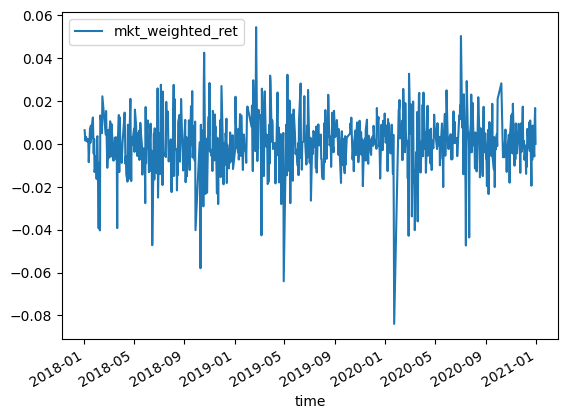

In [66]:
mytest.plot()

In [71]:
(185402848*13.322 - 2453902601) / 2453902601


0.006534138742697293

In [73]:
mytest.shift(1)

,mkt_weighted_ret
time,
2018-01-02,NaN
2018-01-03,0.006337
2018-01-04,0.003489
2018-01-05,0.001443
2018-01-08,0.003258
...,...
2020-12-25,0.008517
2020-12-28,-0.000771
2020-12-29,-0.005885


In [74]:
mytest


,mkt_weighted_ret
time,
2018-01-02,0.006337
2018-01-03,0.003489
2018-01-04,0.001443
2018-01-05,0.003258
2018-01-08,0.001856
...,...
2020-12-25,-0.000771
2020-12-28,-0.005885
2020-12-29,0.010414
